# Assemble green function with ball drop observation
2021.05.09 Kurama Okubo

- 2022.11.23 update for new ball-drop test 
- 2024.1.24 update for master plot
- 2024.7.17 update for the evaluation of attenuation factor (large Qp and Qs)
- 2025.3.16 update for master plot

## Work flow

1. Read isocoord pickle associated with stations
2. Read meta data
3. Read synthetic waveform
4. Preprocess (scaling with M0: scaling factor used in OpenSWPC; convert from disp to vel; time shift + zero padding)
4. Save pickle

In [2]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from obspy.core.utcdatetime import UTCDateTime  
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8

In [3]:
#Parameters
rootdir = "../../SensorCoupling_BallDrop/code/"

simulationtitle = 'balltest_sidecoord_segment_test' # simulation title used in Input.inf of OpenSWPC
fi_hetzsourceprm = './04_numericalmodeling_waveform/4m_sidecoord_v01_Qp10000_Qs10000_v2_airQ10/out/stf_greenstf_prm.dat'

vmean = 6200

In [11]:
# Path for event location table

eventloc_table = rootdir+"../data/balldrop_locations.csv"

# pickle event waveform directory
eventdatadir = '../data/DATA_isocoord' # use the one with large pretrigger

# greens function data directory 
# greendatadir = rootdir+'./04_numericalmodeling_waveform/4m_sidecoord_v01_Qp200_Qs80_v2/out/green/OL00'
greendatadir = './04_numericalmodeling_waveform/4m_sidecoord_v01_Qp10000_Qs10000_v2_airQ10/out/green/OL00'

# output datadir
outputdir = "../data/DATA_greencomparison"

# channel table
channel_finame = '../../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'


In [12]:
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

In [13]:
# read gindex table
df_gindextable = pd.read_csv(rootdir+"../data/gindex_table.csv", index_col=0)
df_gindextable.head()

,index,gid
0,OL01__BD_0220,0
1,OL01__BD_0340,1
2,OL01__BD_0460,2
3,OL01__BD_0580,3
4,OL02__BD_0220,4


In [14]:
# read observation casename  table
df_iso_all = pd.read_csv(rootdir+"../data/balldrop_events_isocoord.csv", index_col=0)
df_iso_all.head()

,OL,datacase,xs,ys,zs,xi,eta,zeta,dist,xi1,eta1,zeta1
OL01__BD_0220,OL01,BD_0220,0.19,0.05,0.07,0.217,-0.006,0.0,0.093622,0.027,-0.056,0
OL01__BD_0340,OL01,BD_0340,0.19,0.05,0.07,0.339,0.001,0.0,0.171761,0.149,-0.049,0
OL01__BD_0460,OL01,BD_0460,0.19,0.05,0.07,0.458,0.001,0.0,0.281292,0.268,-0.049,0
OL01__BD_0580,OL01,BD_0580,0.19,0.05,0.07,0.578,0.004,0.0,0.396938,0.388,-0.046,0
OL02__BD_0220,OL02,BD_0220,0.41,0.05,0.07,0.217,-0.006,0.0,0.212803,-0.193,-0.056,0


In [15]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())

In [16]:
df_iso_all[df_iso_all.OL == 'OL02']

,OL,datacase,xs,ys,zs,xi,eta,zeta,dist,xi1,eta1,zeta1
OL02__BD_0220,OL02,BD_0220,0.41,0.05,0.07,0.217,-0.006,0.0,0.212803,-0.193,-0.056,0
OL02__BD_0340,OL02,BD_0340,0.41,0.05,0.07,0.339,0.001,0.0,0.111095,-0.071,-0.049,0
OL02__BD_0460,OL02,BD_0460,0.41,0.05,0.07,0.458,0.001,0.0,0.098005,0.048,-0.049,0
OL02__BD_0580,OL02,BD_0580,0.41,0.05,0.07,0.578,0.004,0.0,0.187723,0.168,-0.046,0
OL02__BD_0700,OL02,BD_0700,0.41,0.05,0.07,0.698,0.000,0.0,0.300573,0.288,-0.050,0


In [17]:
# Read OpenSWPC output for Hertzian source parameter
df_hertzprm = pd.read_csv(fi_hetzsourceprm, skipinitialspace=True)

print(f'T0={df_hertzprm["T0"].values[0]*1e6:.1f}us, Tc{df_hertzprm["tc"].values[0]*1e6:.2f}us, hertz_fmax={df_hertzprm["hertz_fmax"].values[0]:.2f}N, fz={df_hertzprm["fz"].values[0]:.6f}')

T0=0.0us, Tc6.66us, hertz_fmax=56.19N, fz=0.000208


In [18]:
df_hertzprm

,T0,tc,hertz_fmax,fz
0,0.0,0.000007,56.1889,0.000208


In [19]:
df_hertzprm["T0"]*1e6

0    0.0
Name: T0, dtype: float64

## Assemble observation and synthetic waveform

In [26]:
# Read observation
for stnm in tqdm(AEsensors):
# stnm = AEsensors[8]

    foname = os.path.join(outputdir, "{}_bdwaveform_longpretrig.pickle".format(stnm)) 

    if os.path.exists(foname):
        print("{}_bdwaveform.pickle already exists. skip this case.".format(stnm))
#         continue

    df_iso_st = df_iso_all[df_iso_all.OL==stnm]
    xlimit = [-0.5, 3]
    ylimit = [-1.0, 1.0]

    st_eventsta = Stream()

    #---Start assembling each balldrop event---#
    for dataind in df_iso_st.index:
        #---Read observation data---#
        tr_obs_trim = read(eventdatadir+"/obs_isocoord_{}.pickle".format(dataind))[0]
        tr_obs_trim.stats.dataindex = dataind
        # rename channel
        tr_obs_trim.stats.network = 'BIAX' # 'OY': Observatoin in Y direction
        tr_obs_trim.stats.channel = 'OY' # 'OY': Observatoin in Y direction
        st_eventsta.append(tr_obs_trim)


    for tr_obstmp in st_eventsta:
        #---Read synthetic data---#
        dataind = tr_obstmp.stats.dataindex

        OL, datacase = dataind.split('__')

        # read synthetic green's function
        gid = df_gindextable[df_gindextable['index'] == dataind]['gid'].values[0]

        finame_syn = '{}/{}__{:08d}__OL00__z__fy___.sac'.format(greendatadir, simulationtitle, gid) #y coordinate is corresponding to the perpendicular to the fault surface
        tr_syn = read(finame_syn, format="SAC")[0]

        # restore stats
        tr_syn.stats.network = 'OpenSWPC'
        tr_syn.stats.station = OL
        tr_syn.stats.location = tr_obstmp.stats.location
        tr_syn.stats.channel = 'SY' # NOTE: The original name 'G_Vz_fy_' is misleading; The output of green function in OpenSWPC is not in velocity, but displacement.
        tr_syn.stats.dataindex = dataind
        tr_syn.stats.fz_hetzscale = df_hertzprm['fz'].values[0]

        # rescale source scaling and convert from nm to m
        tr_syn.data = tr_syn.data*tr_syn.stats.fz_hetzscale/1e9

        # store the displacement data for the gain comparison
        tr_syn.data_disp = tr_syn.data
        # convert from displacement to velocity
        tr_syn.differentiate() # NOTE: obspy differentiate uses delta in stats for differentiation.

        # manipulate start and endtime
        # 1. zero pad pretriger and windowlen
        # 2. change starttime

        T0 = df_hertzprm['T0'].values[0] # Origin time used in OpenSWPC

        st_tmp = tr_syn.stats.starttime
        pt = timedelta(milliseconds = tr_obstmp.stats.pretrigger)
        wt = timedelta(milliseconds = tr_obstmp.stats.windowlen)
        ot = timedelta(milliseconds = T0)

        starttime_tmp = st_tmp+ot-pt
        endtime_tmp = st_tmp+ot+wt

        tr_syn_trim = tr_syn.copy() # avoid error in multiple trim
        tr_syn_trim.trim(starttime_tmp, endtime_tmp, pad=True, fill_value=0.0)
        
        tr_syn_trim.stats.starttime =  tr_obstmp.stats.starttime
        
        st_eventsta.append(tr_syn_trim)

    # Save Stream containing a set of balldrop observatoin and synthetic waveform
    if not os.path.exists(outputdir):
        os.makedirs(outputdir) 
        
    st_eventsta.write(foname, format="pickle")

  6%|██▊                                         | 2/32 [00:00<00:01, 18.51it/s]

OL01_bdwaveform.pickle already exists. skip this case.
OL02_bdwaveform.pickle already exists. skip this case.
OL03_bdwaveform.pickle already exists. skip this case.
OL04_bdwaveform.pickle already exists. skip this case.
OL05_bdwaveform.pickle already exists. skip this case.


 25%|███████████                                 | 8/32 [00:00<00:00, 25.74it/s]

OL06_bdwaveform.pickle already exists. skip this case.
OL07_bdwaveform.pickle already exists. skip this case.
OL08_bdwaveform.pickle already exists. skip this case.
OL09_bdwaveform.pickle already exists. skip this case.
OL10_bdwaveform.pickle already exists. skip this case.
OL11_bdwaveform.pickle already exists. skip this case.


 47%|████████████████████▏                      | 15/32 [00:00<00:00, 29.80it/s]

OL12_bdwaveform.pickle already exists. skip this case.
OL13_bdwaveform.pickle already exists. skip this case.
OL14_bdwaveform.pickle already exists. skip this case.
OL15_bdwaveform.pickle already exists. skip this case.
OL16_bdwaveform.pickle already exists. skip this case.
OL17_bdwaveform.pickle already exists. skip this case.
OL18_bdwaveform.pickle already exists. skip this case.
OL19_bdwaveform.pickle already exists. skip this case.


 72%|██████████████████████████████▉            | 23/32 [00:00<00:00, 29.94it/s]

OL20_bdwaveform.pickle already exists. skip this case.
OL21_bdwaveform.pickle already exists. skip this case.
OL22_bdwaveform.pickle already exists. skip this case.
OL23_bdwaveform.pickle already exists. skip this case.
OL24_bdwaveform.pickle already exists. skip this case.
OL25_bdwaveform.pickle already exists. skip this case.


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 29.93it/s]

OL26_bdwaveform.pickle already exists. skip this case.
OL27_bdwaveform.pickle already exists. skip this case.
OL28_bdwaveform.pickle already exists. skip this case.
OL29_bdwaveform.pickle already exists. skip this case.
OL30_bdwaveform.pickle already exists. skip this case.
OL31_bdwaveform.pickle already exists. skip this case.
OL32_bdwaveform.pickle already exists. skip this case.


In [27]:
# check comparison

finame = os.path.join(outputdir, "{}_bdwaveform_longpretrig.pickle".format(AEsensors[12])) 
st = read(finame)
st

12 Trace(s) in Stream:
BIAX.OL13.2860.OY     | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
BIAX.OL13.2980.OY     | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
BIAX.OL13.3100.OY     | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
BIAX.OL13.3220.OY     | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
BIAX.OL13.3340.OY     | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
BIAX.OL13.3460.OY     | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
OpenSWPC.OL13.2860.SY | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
OpenSWPC.OL13.2980.SY | 1970-01-01T00:00:00.00000000Z - 1970-01-01T00:00:00.00045000Z | 10000000.0 Hz, 4501 samples
OpenSWPC.OL13.3100.SY | 1970-01-01T00:00:00.00000

In [28]:
tr_obs = st.select(network="BIAX", location='3100')[0]
tr_syn = st.select(network="OpenSWPC", location='3100')[0] 

In [29]:
tr_obs.stats

         network: BIAX
         station: OL13
        location: 3100
         channel: OY
       starttime: 1970-01-01T00:00:00.00000000Z
         endtime: 1970-01-01T00:00:00.00045000Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 4501
           calib: 1.0
         _format: PICKLE
       dataindex: OL13__BD_3100
            dist: 108.28665661105246
            eta1: -0.051
          i_iter: 1
      origintime: 0.0845615722876972
      pretrigger: 0.05
      processing: ['ObsPy 1.4.1: trim(endtime=UTCDateTime(1970, 1, 1, 0, 0, 0, 485)::fill_value=0.0::nearest_sample=True::pad=True::starttime=UTCDateTime(1970, 1, 1, 0, 0, 0, 35))']
           tpick: 0.016938427712302806
       windowlen: 0.4
             xi1: -0.065
           zeta1: 0

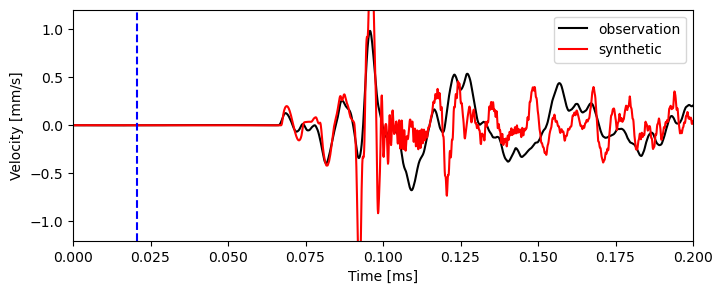

In [30]:
tvec = tr_syn.times() * 1e3

xlimit = [0, 0.2] #[-1.5, 20.5]
ylimit = [-1.2, 1.2]
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(tvec, tr_obs.data*1e3, 'k-', label="observation")
ax.plot(tvec, tr_syn.data*1e3, 'r-', label="synthetic")
ax.axvline(tr_obs_trim.stats.tpick, c = 'b', ls = '--')
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Velocity [mm/s]")
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.legend()

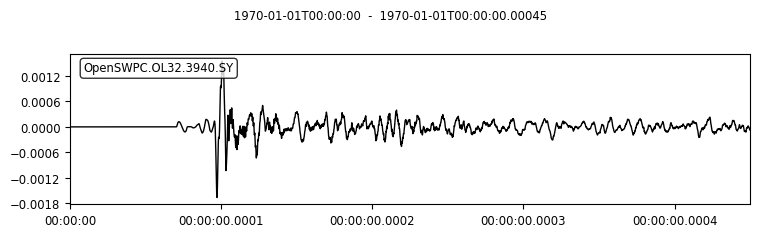

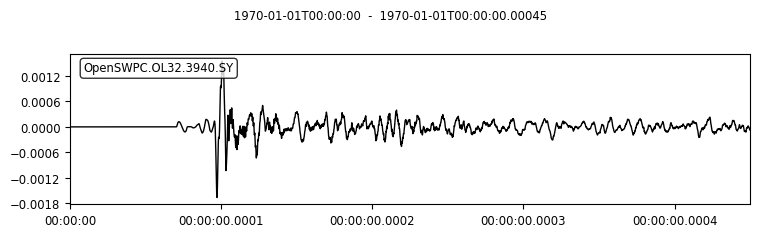

In [31]:
tr_syn_trim.plot()